## import library

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Embedding
from keras.layers import SpatialDropout1D, Dropout, add, concatenate
from keras.layers import SimpleRNN, Bidirectional, GlobalMaxPool1D, GlobalAveragePooling1D, LSTM
from keras.optimizers import Adam
from keras.preprocessing import text, sequence
#from keras.callbacks import LearningRateScheduler

Using TensorFlow backend.


In [2]:
MAX_FEATURES = 100000
TARGET_COLUMN = "target"
FEATURE_COLUMN = "comment_text"

all_identity_columns = ['asian', 'atheist', 'bisexual',
       'black', 'buddhist', 'christian', 'female', 'heterosexual', 'hindu',
       'homosexual_gay_or_lesbian', 'intellectual_or_learning_disability',
       'jewish', 'latino', 'male', 'muslim', 'other_disability',
       'other_gender', 'other_race_or_ethnicity', 'other_religion',
       'other_sexual_orientation', 'physical_disability',
       'psychiatric_or_mental_illness', 'transgender', 'white',
       'sexual_explicit']

AUX_COLUMNS = ['severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat']

## Read Data

In [3]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

# Data Exploration

In [4]:
print("Train data shape: {}".format(train.shape))
print("Test data shape: {}".format(test.shape))

Train data shape: (1804874, 45)
Test data shape: (97320, 2)


In [5]:
#data exploration
train.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.0,4,47


In [6]:
test.head()

,id,comment_text
0,7097320,[ Integrity means that you pay your debts.]\n\...
1,7097321,This is malfeasance by the Administrator and t...
2,7097322,@Rmiller101 - Spoken like a true elitist. But ...
3,7097323,"Paul: Thank you for your kind words. I do, in..."
4,7097324,Sorry you missed high school. Eisenhower sent ...


### Columns contains NAN values

In [7]:
columns_contains_nan_values = train.columns[train.isnull().any()]

In [8]:
train[columns_contains_nan_values].isnull().sum()

asian                                  1399744
atheist                                1399744
bisexual                               1399744
black                                  1399744
buddhist                               1399744
christian                              1399744
female                                 1399744
heterosexual                           1399744
hindu                                  1399744
homosexual_gay_or_lesbian              1399744
intellectual_or_learning_disability    1399744
jewish                                 1399744
latino                                 1399744
male                                   1399744
muslim                                 1399744
other_disability                       1399744
other_gender                           1399744
other_race_or_ethnicity                1399744
other_religion                         1399744
other_sexual_orientation               1399744
physical_disability                    1399744
psychiatric_o

# Exploration Visualization

In [9]:
all_data = train.copy()

In [10]:
def split_pos_neg_class(data):
    return data[data['target'] >= 0.5], data[data['target'] < 0.5]

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
def plot_diff_between_classes(pos, neg):
    import seaborn as sns
    x = [len(pos), len(neg)]
    y = ["positive", "negative"]
    ax = sns.barplot(y,x,palette="Blues_d")
    plt.show()
    del ax

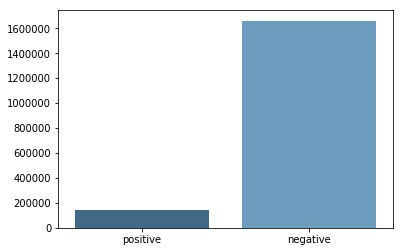

In [14]:
# we note that no balanced between classes 
pos, neg = split_pos_neg_class(all_data)
plot_diff_between_classes(pos, neg)

## Visualization Weighted Toxic of IDENTITY COLUMNS

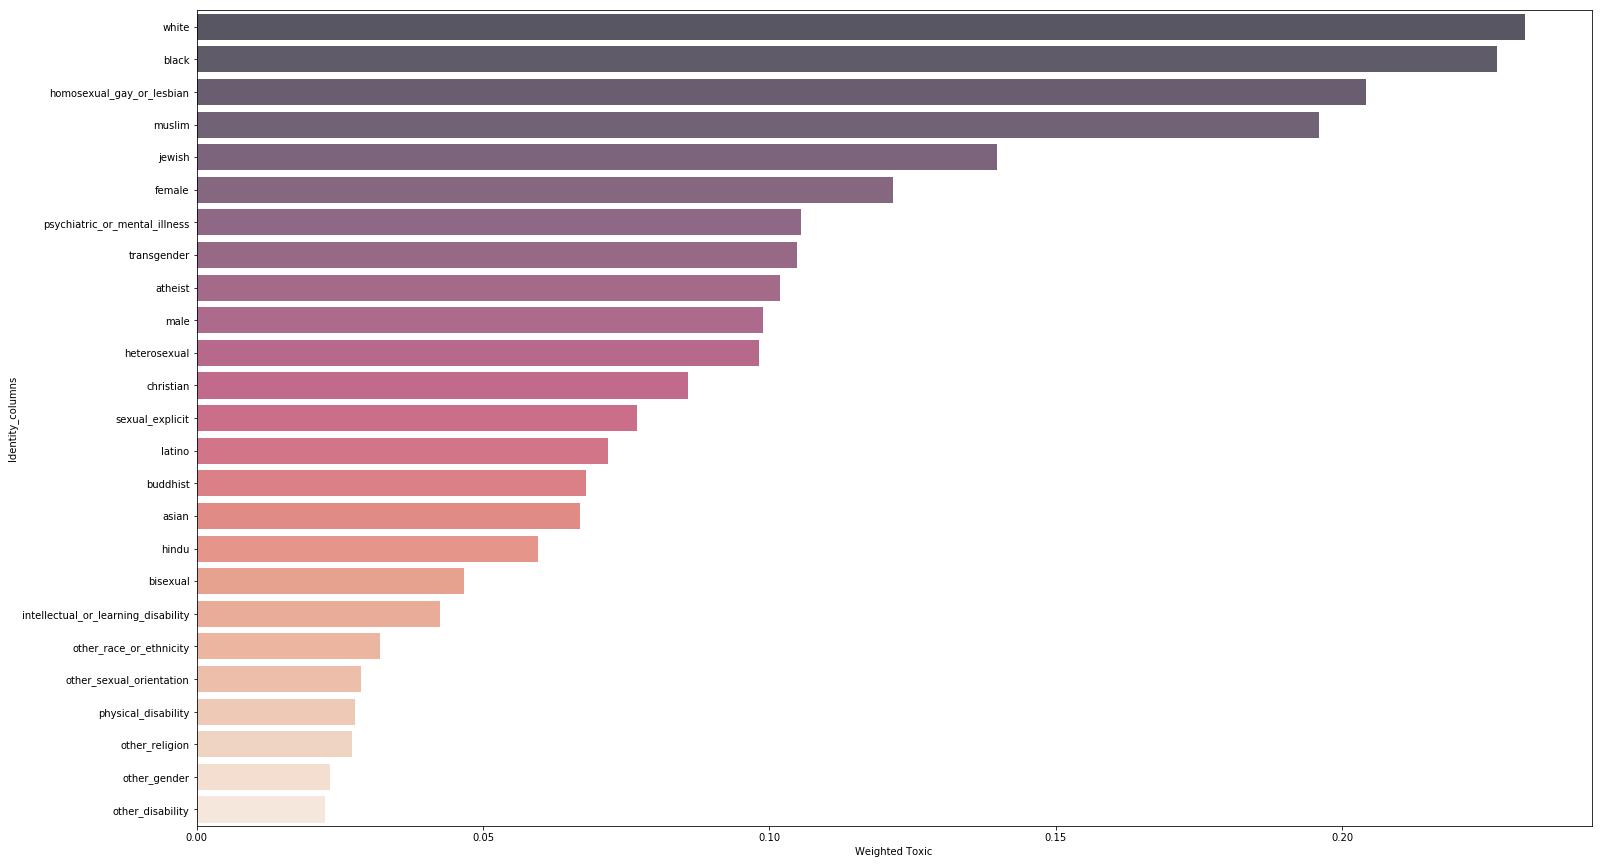

In [15]:
import seaborn as sns

data = all_data.loc[:, ['target']+list(all_data[all_identity_columns])]
toxic_w = data.iloc[:, 1:].multiply(data.iloc[:, 0], axis="index").sum()/data.iloc[:, 1:][data.iloc[:, 1:]>0].count()
toxic_w = toxic_w.sort_values(ascending=False)

plt.figure(figsize=(25,15))
ax = sns.barplot(toxic_w.values, toxic_w.index, palette="rocket", alpha=0.7)
plt.ylabel('Identity_columns')
plt.xlabel('Weighted Toxic')
plt.show()
del sns,ax

# Data Prepocessing

In [16]:
# we will sufficient with these highest toxic columns.
IDENTITY_COLUMNS = [
    'white', 'black', 'homosexual_gay_or_lesbian', 'muslim', 'jewish',
    'female', 'psychiatric_or_mental_illness', 'transgender', 'atheist',
    'male', 'heterosexual', 'sexual_explicit', 'christian', 'latino', 'buddhist',
    'asian', 'hindu', 'bisexual']

### drop UnNeeded data (comment_id, metadata columns, and low toxic identity columns)

In [17]:
columns_to_drop = ["id", "created_date",
                   "publication_id", "parent_id",
                   "article_id", "identity_annotator_count",
                   "toxicity_annotator_count","rating","funny","wow","sad","likes","disagree","other_gender",
                   "other_race_or_ethnicity", "other_religion","intellectual_or_learning_disability",
                   "other_sexual_orientation", "physical_disability"]
all_data.drop(axis = 1, columns = columns_to_drop, inplace=True)

In [18]:
print("Remaining columns: {}".format(np.array(all_data.columns)))
print("Number of columns: {}".format(all_data.shape[1]))

Remaining columns: ['target' 'comment_text' 'severe_toxicity' 'obscene' 'identity_attack'
 'insult' 'threat' 'asian' 'atheist' 'bisexual' 'black' 'buddhist'
 'christian' 'female' 'heterosexual' 'hindu' 'homosexual_gay_or_lesbian'
 'jewish' 'latino' 'male' 'muslim' 'other_disability'
 'psychiatric_or_mental_illness' 'transgender' 'white' 'sexual_explicit']
Number of columns: 26


## Make train data with no NAN values in identity columns
<b>then take this droped rows in test and evaluation</b>

In [19]:
#drop each row which its all identity columns is null in training data to use it in test, validation data
train_data = all_data.dropna(how="any")
remaining_data = all_data[~all_data.index.isin(train_data.index)]

In [20]:
train_data.shape

(405130, 26)

In [21]:
remaining_data.shape

(1399744, 26)

## Data Split

Our goal is to make two class balaced between toxic or not toxic comment

train_data have 46035 positive sample and 359095 negative sample


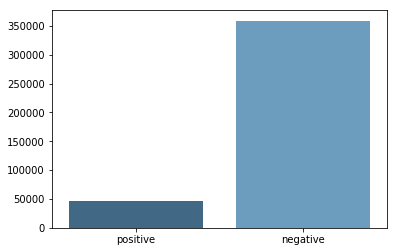

In [22]:
pos_class, neg_class = split_pos_neg_class(train_data)
print("train_data have {} positive sample and {} negative sample".format(pos_class.shape[0], neg_class.shape[0]))
plot_diff_between_classes(pos_class, neg_class)

remaining_data have 98299 positive sample and 1301445 negative sample


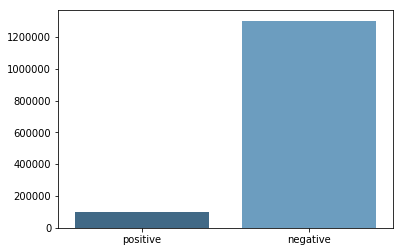

In [23]:
remain_pos_class, remain_neg_class = split_pos_neg_class(remaining_data)
print("remaining_data have {} positive sample and {} negative sample".format(remain_pos_class.shape[0], remain_neg_class.shape[0]))
plot_diff_between_classes(remain_pos_class, remain_neg_class)

In [24]:
# func to reordring data in randomly way
def shuffle_data(data):
    return data.sample(frac=1).reset_index(drop=True)

## make data balanced between two classes

In [25]:
# Make training data from ~46k pos class and ~46k from negative class
# due to the pos_class sample less than neg_class sample.
train_data = pd.concat([pos_class, neg_class[:pos_class.shape[0]]])
train_data = shuffle_data(train_data)
print("train data contain {} samples".format(train_data.shape[0]))

train data contain 92070 samples


In [26]:
# Create evaluation data by prop 4:1 from training data ~20k
validate_data = pd.concat([remain_pos_class[:10000], remain_neg_class[:10000]])
validate_data = shuffle_data(validate_data)
print("validation data contain {} samples".format(validate_data.shape[0]))

validation data contain 20000 samples


In [27]:
#Create testing data by prop 4:1 from training data ~20k
test_data = pd.concat([remain_pos_class[20000:30000], remain_neg_class[20000:30000]])
test_data = shuffle_data(test_data)
print("testing data contain {} samples".format(test_data.shape[0]))

testing data contain 20000 samples


## Split data into feature and target

In [28]:
x_train = train_data['comment_text'].values 
y_train = train_data['target'].apply(lambda x: x >= 0.5).values
aux_y_train = train_data[AUX_COLUMNS].apply(lambda x: x >= 0.4).values

x_validate = validate_data['comment_text'].values
y_validate = validate_data['target'].apply(lambda x: x >= 0.5).values
aux_y_validate = validate_data[AUX_COLUMNS].apply(lambda x: x >= 0.4).values

x_test = test_data['comment_text'].values
y_test = test_data['target'].apply(lambda x: x >= 0.5).values
aux_y_test = test_data[AUX_COLUMNS].apply(lambda x: x >= 0.4).values

## Create Corpus and Train Tokenizer

In [29]:
corpus = list(all_data['comment_text'].values) + list(test['comment_text'].values)

In [30]:
word_tokenizer = text.Tokenizer(num_words=MAX_FEATURES)
word_tokenizer.fit_on_texts(corpus) #fit on corpus

In [31]:
vocab_length = len(word_tokenizer.word_index) + 1
vocab_length

409328

#### Find the longest sentence to make padding for each lower sentence

In [32]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [33]:
#find the number of words in the longest sentence and then to apply padding 
#to the sentences having shorter lengths than the length of the longest sentence.

from nltk.tokenize import word_tokenize

word_count = lambda sentence: len(word_tokenize(sentence))
longest_sentence = max(x_train, key=word_count)
length_longest_sentence = len(word_tokenize(longest_sentence))
print(length_longest_sentence)

347


In [34]:
# I think that 347 it very logest to pad all the lower sentence to this length
INPUT_LENGTH = length_longest_sentence-107

## Convert Text to numerical data

In [35]:
embedded_x_train = word_tokenizer.texts_to_sequences(x_train)
embedded_x_validate = word_tokenizer.texts_to_sequences(x_validate)
embedded_x_test = word_tokenizer.texts_to_sequences(x_test)

## Padding Sequence to fixed length

In [36]:
pad_x_train = sequence.pad_sequences(embedded_x_train, INPUT_LENGTH, padding='post')
pad_x_validate = sequence.pad_sequences(embedded_x_validate, INPUT_LENGTH, padding='post')
pad_x_test = sequence.pad_sequences(embedded_x_test, INPUT_LENGTH, padding='post')

In [38]:
pad_x_train[1]

array([   10, 17767,     8,     1,   101,  5977,  1012,   349,  1567,
       17713,     2,    15,     1,  1673,     4,   234,   317,    16,
         136,    24,    35,  1748, 29320,    24,    53,    42,   339,
          10,    32,    35,   174,   352,    10,   122, 18463,  2273,
           3,   321,     2,     1,  1714,    35,   352,     6,  4990,
          49,    21,    12,     6,  2450,    49,    21,  1326,     6,
        2757,    23,  3165,    14,    60,  1212,     8,  1654,    41,
        1314, 23774,     8,    17,    66,   240,   156,    35,  4077,
        9415,    88,    27,    86,    89,    75,    43,    30,    10,
         119,     7,    18,   295,  1586,     8,   216,  2845,  6854,
          16,    76,    37,  1970,    25,  7272,    30,    25,  9254,
          84,  4990,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

## Word Embedding

In [39]:
glove_file = open("glove.6B.300d.txt",encoding='utf8')

**We will create a dictionary that will contain words as keys and the corresponding 300 dimensional vectors
as values, in the form of an array.**

In [40]:
embedding_dict = {}
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embedding_dict[word] = vector_dimensions
glove_file.close()

<b>We want the word embeddings for only those words that are present in our corpus,We will create a two dimensional numpy array of  409328 (size of vocabulary) rows and 300 columns. The array will initially contain zeros. The array will be named as embedding_matrix</b>

In [41]:
embedding_matrix = np.zeros((vocab_length, 300))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embedding_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

Our embedding_matrix now contains pretrained word embeddings for the words in our corpus.
let us build our model

## Generate Sample Importance (Training Weights) array using IDENTITY_COLUMNS
<b>i'm taking this part from <a src="https://www.kaggle.com/kunwar31/simple-lstm-with-identity-parameters-fastai"> kaggle Notebook </a>, i'm trying to build it by myself but i faild</b>

In [42]:
for column in IDENTITY_COLUMNS + [TARGET_COLUMN]:
    train_data[column] = np.where(train_data[column] >= 0.5, True, False)

sample_weights = np.ones(len(x_train), dtype=np.float32)
sample_weights += train_data[IDENTITY_COLUMNS].sum(axis=1)
sample_weights += train_data[TARGET_COLUMN] * (~train_data[IDENTITY_COLUMNS]).sum(axis=1)
sample_weights += (~train_data[TARGET_COLUMN]) * train_data[IDENTITY_COLUMNS].sum(axis=1) * 5
sample_weights /= sample_weights.mean()

## plot model accuracy - loss result

In [48]:
def plot_model_result(model, epochs):
    hist = []
    for key, values in model.history.items():
        hist.append(values)


    EPO = np.arange(1,epochs+1)

    fig, ax = plt.subplots(2, 2,figsize=(15,15), sharex=True, sharey=True)
    ax[0][0].plot(EPO, hist[-2], marker='v', linestyle='--', color='b')
    ax[0][1].plot(EPO, hist[-1], marker='v', linestyle='--', color='g')
    ax[0][0].plot(EPO, hist[3], marker='o', color='m')
    ax[0][1].plot(EPO, hist[4], marker='o', color='r')
    ax[0][0].set_ylabel('acc')
    #ax[0][0].set_xticks(EPO)
    ax[0][0].set_title("target VS. val_target (acc)", size=10)
    ax[0][1].set_title("aux VS. val_aux (acc)", size=10)

    ax[1][0].plot(EPO,hist[-4], marker='v', linestyle='--', color='b')
    ax[1][1].plot(EPO, hist[-3], marker='v', linestyle='--', color='g')
    ax[1][0].plot(EPO, hist[1], marker='o', color='m')
    ax[1][1].plot(EPO, hist[2], marker='o', color='r')
    ax[1][0].set_xlabel('epochs')
    ax[1][0].set_ylabel('loss')
    #ax[1][0].set_xticks(EPO)
    ax[1][0].set_title("target VS. val_target (loss)", size=10)
    ax[1][1].set_title("aux VS. val_aux(loss)", size=10)


    plt.show()
    del ax, fig

## Benchmark model (base_model)

<b>In order we have two output layer we will use keras functional API not sequential </b>

In [44]:
#input layer
bm_inputs = Input(shape=(INPUT_LENGTH,))
#embedding layer
bm_embedded = Embedding(vocab_length, 300,weights=[embedding_matrix], trainable=False)(bm_inputs)
#one lstm layer
bm_rnn = SimpleRNN(units=100, activation="relu")(bm_embedded)
#one dence layer
bm_dence = Dense(200, activation='tanh')(bm_rnn)
#output layers
#first output tell us if comment is toxic or not 
bm_target = Dense(1, activation='sigmoid', name='target')(bm_dence)
#second output tell us the degree of toxic in comment
bm_aux = Dense(5, activation='sigmoid', name='aux')(bm_dence)

#create model
b_model = Model(inputs=bm_inputs, outputs=[bm_target, bm_aux], name='base_model')
#print summary
b_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 240)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 240, 300)     122798400   input_1[0][0]                    
__________________________________________________________________________________________________
simple_rnn_1 (SimpleRNN)        (None, 100)          40100       embedding_1[0][0]                
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 200)          20200       simple_rnn_1[0][0]               
__________________________________________________________________________________________________
target (De

In [45]:
b_model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

In [46]:
b_model_history = b_model.fit(pad_x_train,
                              [y_train, aux_y_train],
                              batch_size = 512,
                              epochs=20,
                              verbose=1,
                              validation_data=(pad_x_validate, [y_validate, aux_y_validate]))

Train on 92070 samples, validate on 20000 samples
Epoch 1/20
92070/92070 [==============================] - 21s 223us/step - loss: 1.0065 - target_loss: 0.6964 - aux_loss: 0.3101 - target_acc: 0.5001 - aux_acc: 0.8773 - val_loss: 0.9482 - val_target_loss: 0.6932 - val_aux_loss: 0.2549 - val_target_acc: 0.5000 - val_aux_acc: 0.8913
Epoch 2/20
92070/92070 [==============================] - 20s 215us/step - loss: 0.9697 - target_loss: 0.6939 - aux_loss: 0.2758 - target_acc: 0.4989 - aux_acc: 0.8787 - val_loss: 0.9511 - val_target_loss: 0.6941 - val_aux_loss: 0.2570 - val_target_acc: 0.5000 - val_aux_acc: 0.8913
Epoch 3/20
92070/92070 [==============================] - 20s 216us/step - loss: 0.9703 - target_loss: 0.6945 - aux_loss: 0.2758 - target_acc: 0.5001 - aux_acc: 0.8787 - val_loss: 0.9553 - val_target_loss: 0.6960 - val_aux_loss: 0.2593 - val_target_acc: 0.5000 - val_aux_acc: 0.8913
Epoch 4/20
92070/92070 [==============================] - 20s 216us/step - loss: 0.9698 - target_loss

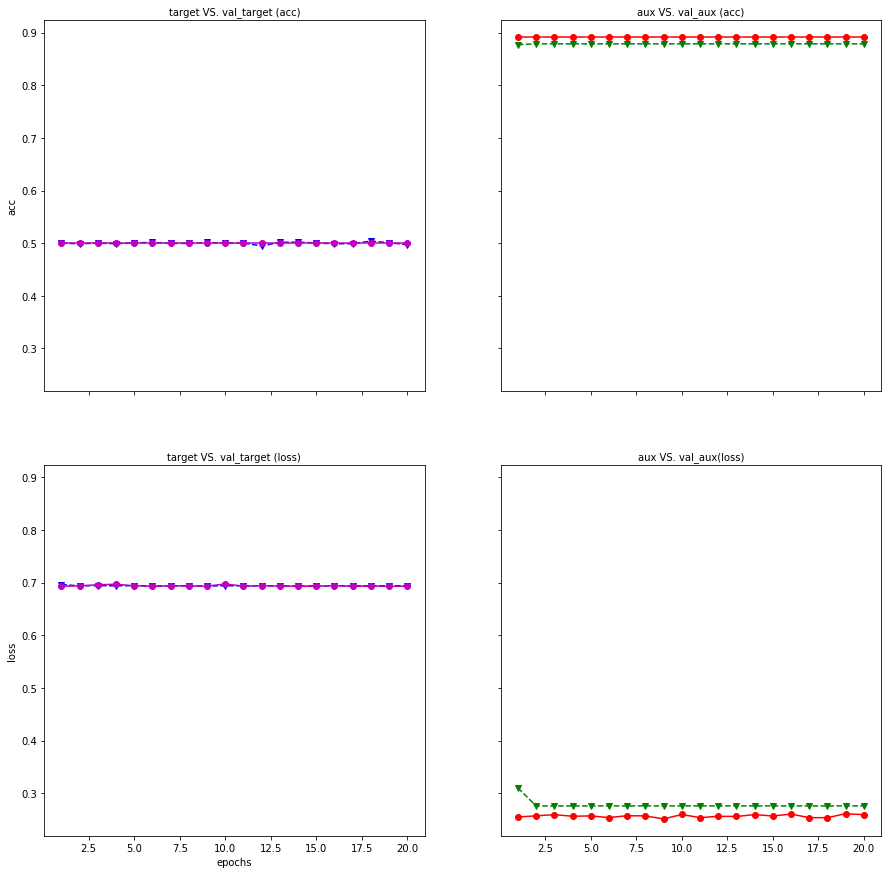

In [49]:
plot_model_result(b_model_history, 20)

In [50]:
loss, out1_loss, out2_loss, out1_acc, out2_acc = b_model.evaluate(pad_x_test, [y_test, aux_y_test] , batch_size=512)
print("total loss : ",loss)
print("target loss : ", out1_loss)
print("toxic degree loss : ", out2_loss)
print("target accuarcy : ", out1_acc)
print("toxic degree accuracy : ", out2_acc)

20000/20000 [==============================] - 2s 85us/step
total loss :  0.939489178276
target loss :  0.693147292519
toxic degree loss :  0.24634187851
target accuarcy :  0.5
toxic degree accuracy :  0.892129983902


# Build Main Model with two OUTPUT

In [51]:
from keras.layers import Dropout

In [51]:
#input layer
inputs = Input(shape=(INPUT_LENGTH,))

#embedding layer
embedding = Embedding(*embedding_matrix.shape, weights=[embedding_matrix], trainable=False)(inputs)
#dropout layer
dropout1 = Dropout(0.2)(embedding)

#Recurrent nueral network layers
lstm1 = Bidirectional(LSTM(128, return_sequences=True))(dropout1)
lstm2 = Bidirectional(LSTM(128, return_sequences=True))(lstm1)

#Pooling layer: minizing feature map
pool = GlobalMaxPool1D()(lstm2)

#dropout layer
dropout = Dropout(0.2)(pool)


#Hidden dence layer
dence1 = Dense(200, activation='tanh')(dropout)


#output layers
target = Dense(1, activation='sigmoid', name='target')(dence1) # target output
aux = Dense(5, activation='sigmoid', name='aux')(dence1) # aux output

#keras functional API model
model = Model(inputs = inputs, outputs=[target, aux])

#show model summary
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 240)          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 240, 300)     122798400   input_2[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 240, 300)     0           embedding_2[0][0]                
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 240, 256)     439296      dropout_1[0][0]                  
__________________________________________________________________________________________________
bidirectio

In [52]:
model.compile(optimizer="Adam", loss='binary_crossentropy', metrics=['accuracy'])

## Train Model

In [58]:
w2 = np.ones_like(sample_weights)
model_history = model.fit(pad_x_train,[y_train, aux_y_train],
                          batch_size = 512,
                          validation_data=(pad_x_validate, [y_validate, aux_y_validate] ),
                          epochs=20,
                          verbose=1,
                          sample_weight={"out1":sample_weights, "out2":w2})

Train on 92070 samples, validate on 20000 samples
Epoch 1/20
92070/92070 [==============================] - 358s 4ms/step - loss: 0.5271 - target_loss: 0.3617 - aux_loss: 0.1654 - target_acc: 0.8411 - aux_acc: 0.9354 - val_loss: 0.5301 - val_target_loss: 0.3856 - val_aux_loss: 0.1445 - val_target_acc: 0.8375 - val_aux_acc: 0.9487
Epoch 2/20
92070/92070 [==============================] - 355s 4ms/step - loss: 0.4822 - target_loss: 0.3326 - aux_loss: 0.1496 - target_acc: 0.8552 - aux_acc: 0.9401 - val_loss: 0.4070 - val_target_loss: 0.2953 - val_aux_loss: 0.1117 - val_target_acc: 0.8737 - val_aux_acc: 0.9594
Epoch 3/20
92070/92070 [==============================] - 351s 4ms/step - loss: 0.4535 - target_loss: 0.3148 - aux_loss: 0.1387 - target_acc: 0.8639 - aux_acc: 0.9434 - val_loss: 0.3952 - val_target_loss: 0.2933 - val_aux_loss: 0.1019 - val_target_acc: 0.8754 - val_aux_acc: 0.9628
Epoch 4/20
92070/92070 [==============================] - 360s 4ms/step - loss: 0.4269 - target_loss: 0.

## Visualize Training process

The returned "history" object holds a record of the loss values and metric values during training

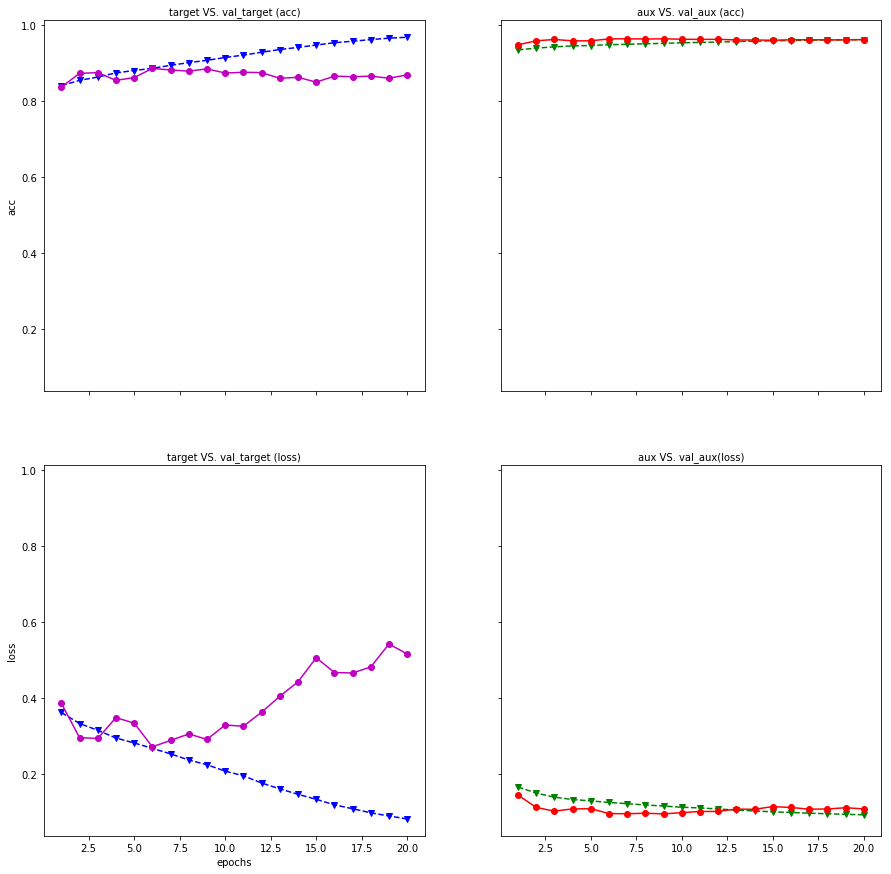

In [59]:
plot_model_result(model_history, 20)

## Evaluate Model 

In [60]:
loss, out1_loss, out2_loss, out1_acc, out2_acc = model.evaluate(pad_x_test, [y_test, aux_y_test] , batch_size=512)
print("total loss : ",loss)
print("target loss : ", out1_loss)
print("toxic degree loss : ", out2_loss)
print("target accuarcy : ", out1_acc)
print("toxic degree accuracy : ", out2_acc)

20000/20000 [==============================] - 23s 1ms/step
total loss :  0.459162030029
target loss :  0.368820946789
toxic degree loss :  0.0903410805583
target accuarcy :  0.90245
toxic degree accuracy :  0.96855


## Try NEW COMMENT

In [61]:
import seaborn as sns
def classify_comment(comment):
    embedded_comment = word_tokenizer.texts_to_sequences([comment])
    pad_comment = sequence.pad_sequences(embedded_comment, INPUT_LENGTH, padding='post')
    x = model.predict(pad_comment)
    
    target = x[0][0][0]
    aux_result = x[1][0]
   
    plt.figure(figsize=(20,10))
    sns.set(font_scale=3)
    ax = sns.barplot(x = AUX_COLUMNS, y = aux_result, alpha=0.8)
    comment_is = "toxic" if target >= 0.5 else "good"
    probability = target if comment_is == "toxic" else 1- target
    title = "Model classifiy comment as: {} , with probability({:.2f})\n Toxic degree".format(comment_is, probability)
    plt.title(title)
    plt.ylabel('Toxic Propability')
    plt.xlabel('Target')
    plt.show()
    del ax


hello world i like to help poor people, but not black of them


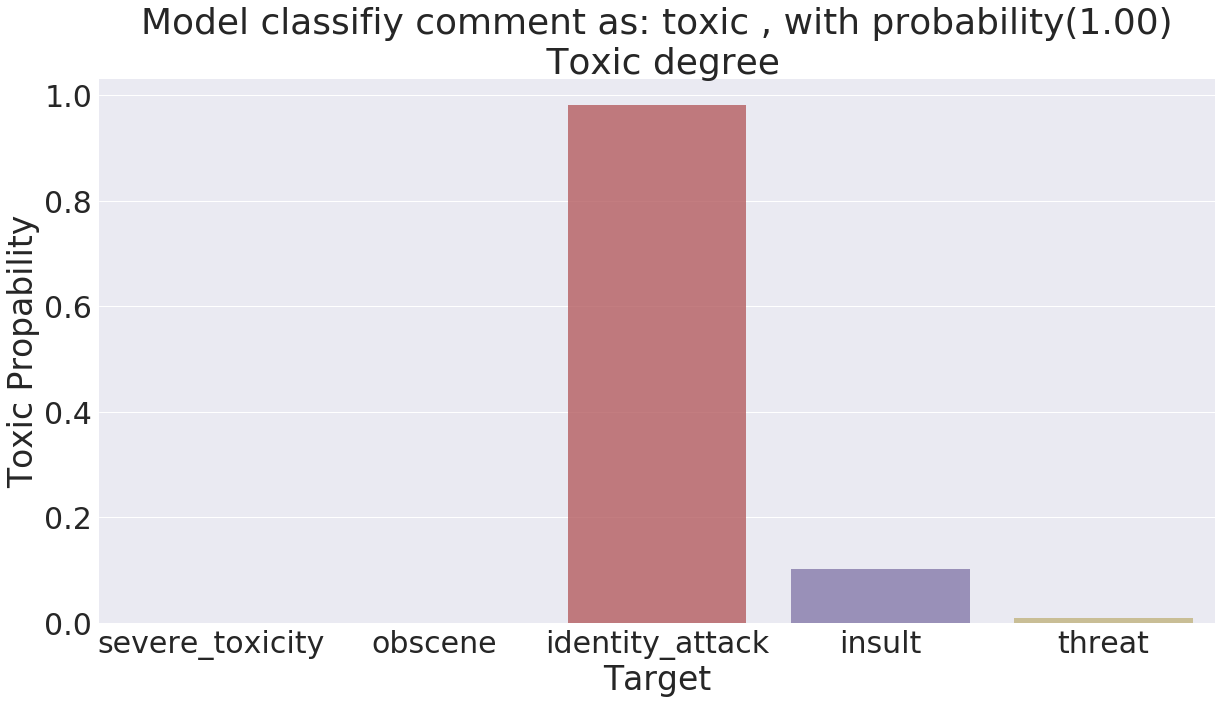

In [66]:
comment = input()
classify_comment(comment)

hello world i like to help poor people


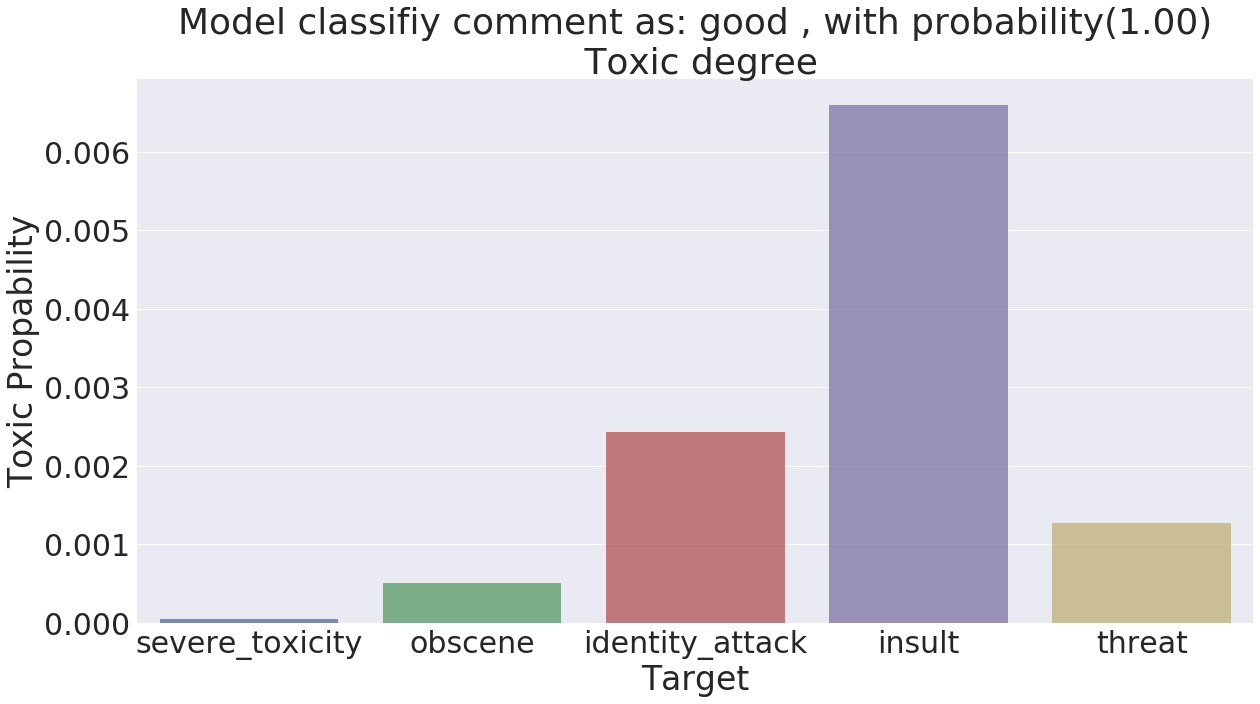

In [68]:
comment = input()
classify_comment(comment)

poor man is bad


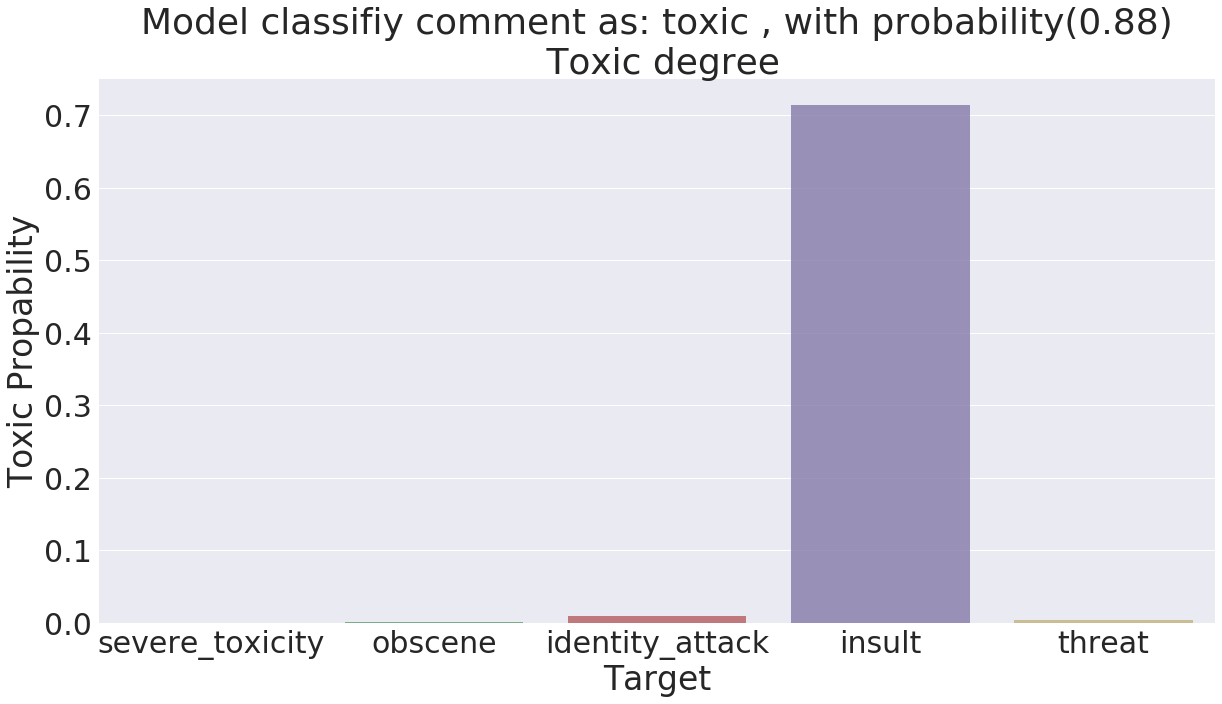

In [64]:
comment = input()
classify_comment(comment)

# Save Model for later use 

In [ ]:
model.save("toxic_classifier.h5")

# If we want laod it

In [ ]:
from keras.models import load_model
new_model = load_model("toxic_classifier.h5")